In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
import MyVolumeLight

In [2]:
def GetTestPicture(numbero_uno):
    global myNormal, myPhoto, myVector, myAlbedo, myMask, myDepth
    myNormal = np.load('BigDataCubes\CombinedDatasets\Part0Normals.npy')[numbero_uno]
    myPhoto = np.load('BigDataCubes\CombinedDatasets\Part0Photos.npy')[numbero_uno]
    myVector = np.load('BigDataCubes\CombinedDatasets\Part0Vectors.npy')[numbero_uno]
    myAlbedo = np.load('BigDataCubes\CombinedDatasets\Part0Albedos.npy')[numbero_uno]
    myMask = np.load('BigDataCubes\CombinedDatasets\Part0Masks.npy')[numbero_uno]
    myDepth = np.load('BigDataCubes\CombinedDatasets\Part0Depth.npy')[numbero_uno]

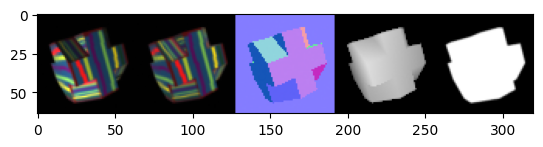

In [34]:
numbero_uno = 3# 3 - good donut
blurNormal = np.load('Sharpening/SharpenInputs/small_blurry_predictions.npy')[numbero_uno]
GetTestPicture(numbero_uno)
plt.imshow(np.concatenate([myPhoto, myAlbedo, myNormal, myDepth, myMask], axis = 1).astype("float32"))
#plt.imshow(myPhoto.astype("float32"))

In [4]:
def calculate_lighting(normal, light_direction):
    light_direction = light_direction / np.linalg.norm(light_direction)
    intensity = np.dot(normal, light_direction)
    return max(intensity, 0)  

In [5]:
def UpdateLightMap():
    global lightmap
    light_dir = myVector
    lightmap = np.zeros((64,64,3))
    for x in range(64):
      for y in range(64):
          one_normal = myNormal[x,y]
          intense = calculate_lighting(one_normal, light_dir)
          lightmap[x,y] = np.array([1,1,1]) * intense


<b>Формулы для плоского освещения</b> <p>
Работает не вполне корректно, так как освещается не объемный 3D объект, а всего лишь плоскость. Но в целом близко.
Нужно либо натренировать отдельную нейронку для освещения, либо же получить карту удаленности пикселя от камеры,
и соответственно его расположение в пространстве

In [8]:
ratio = 0.8
light_color = np.array([1,1,1])
light_intensity = 0.5

In [9]:
d = """
light_direction_normalized = myVector / np.linalg.norm(myVector)
intensity = np.dot(myNormal, light_direction_normalized)
intensity = intensity - np.min(intensity)
intensity = intensity ** (1 / light_intensity)
intensity = np.stack([intensity, intensity, intensity], axis=2)
print(intensity.shape, np.max(intensity))
# Applying
newThing = myAlbedo * intensity * light_intensity
#newThing = newThing * ratio + intensity * (1 - ratio)
newThing = newThing * myMask
"""

In [10]:
np.argmax(myAlbedo[0])

0

In [11]:
def light3D(my_normal, light_point, my_albedo, my_mask):
    light_direction_normalized = (light_point / np.linalg.norm(light_point))
    intensity = np.dot(my_normal, light_direction_normalized)
    intensity = np.clip(intensity, 0, 10)
    intensity = np.stack([intensity, intensity, intensity], axis=2)
    intensity = intensity ** 0.75 #** 0.5
    intensity = intensity * light_color
    
    newThing = (my_albedo * 2 * intensity) * my_mask  # ** (1 / light_intensity)
    return newThing, intensity
# Помоему картинка не складывается потому что в normal map нету объема, 

In [12]:
def light3Dsingular(normal_px, albedo_px, light_point, x, y, depth, 
                    specular_color = 0,      ambient_color = 0, 
                    reflection_factor = 4,   light_strength = 1,):
    axis_center = np.array([0.5,0.5,0.5]); # Центр объекта в blender находится на 0,0,0, но здесь координаты от 0 до 1, поэтому я смещаю.
    camera_pos = np.array([0.5,0.5,2]);
    camera_pos = camera_pos - axis_center
    #axis_center = np.array([0,0,0]);
    x = x / 64; y = y / 64; depth; # Все должнры нормализоваться до 0-1
    specular_color = np.array([specular_color,specular_color,specular_color]); 
    ambient_color = np.array([ambient_color,ambient_color, ambient_color]);
    pixel_pos = np.array([x,y,depth[0]]) - axis_center # смещение относительно axis_center. Также вокруг центра вращается источник освещения
    
    l_d = light_point - pixel_pos
    v_len = np.linalg.norm(l_d)
    lightdir_norm  = np.array([l_d[0] / v_len, l_d[1] / v_len, l_d[2] / v_len])
    #color = ambient + strength * diffuse * max([0,0,0], dot(normal, light_dir))
    #print(l_d, lightdir_norm, v_len)
    v_len = v_len if v_len > 0.001 else 0.001
    diffuse_light = max(0,  np.dot(normal_px, lightdir_norm)) / v_len

    cemera_vector = camera_pos - pixel_pos
    camvec_norm  = (cemera_vector / np.linalg.norm(cemera_vector))
    reflection_vector = (2 * (np.dot(normal_px, lightdir_norm))) * normal_px - lightdir_norm
    specular_light = max(0,  np.dot(reflection_vector, camvec_norm)) ** reflection_factor
    
    #print(diffuse_light)
    #color = ambient_light + diffuse_light + spceular_light
    color =(ambient_color * albedo_px  
            + albedo_px * light_strength * diffuse_light
            + specular_color * specular_light
           )
    color = (min(1, color[0]), min(1, color[1]), min(1, color[2]))
    
    return color

In [69]:
def light3Dspecular(normal_px, albedo_px, light_point, x, y, depth, 
                    light_strength = 1, 
                    specular_color = 0, reflection_factor = 4  ):
    axis_center = np.array([0.5,0.5,0.5]); # Центр объекта в blender находится на 0,0,0, но здесь координаты от 0 до 1, поэтому я смещаю.
    camera_pos = np.array([0.5,0.5,2]);
    camera_pos = camera_pos - axis_center
    #axis_center = np.array([0,0,0]);
    x = x / 64; y = y / 64; depth; # Все должнры нормализоваться до 0-1
    specular_color = np.array([specular_color,specular_color,specular_color]); 

    pixel_pos = np.array([x,y,depth[0]]) - axis_center # смещение относительно axis_center. Также вокруг центра вращается источник освещения

    l_d = light_point - pixel_pos
    v_len = np.linalg.norm(l_d)
    v_len = v_len if v_len > 0.001 else 0.001
    lightdir_norm  = np.array([l_d[0] / v_len, l_d[1] / v_len, l_d[2] / v_len])

    
    is_visible = np.dot(normal_px, lightdir_norm)
    specular_light = 0
    
    if is_visible > 0:
        cemera_vector = camera_pos - pixel_pos
        camvec_norm  = (cemera_vector / np.linalg.norm(cemera_vector))
        reflection_vector = (2 * (np.dot(normal_px, lightdir_norm))) * normal_px - lightdir_norm
        reflection_vector = reflection_vector / np.linalg.norm(reflection_vector)
        specular_light = max(0,  np.dot(reflection_vector, camvec_norm)) ** reflection_factor / v_len 
    

    color = specular_color * specular_light
    color = (min(1, color[0]), min(1, color[1]), min(1, color[2]))
    
    return color

In [61]:
def light3Ddiffuse(normal_px, albedo_px, light_point, 
                       x, y, depth, 
                       light_strength = 1, value1 =0, value2=0, value3=0):
    axis_center = np.array([0.5,0.5,0.5]); # Центр объекта в blender находится на 0,0,0, но здесь координаты от 0 до 1, поэтому я смещаю.
    x = x / 64; y = y / 64; depth; # Все должнры нормализоваться до 0-1
    pixel_pos = np.array([x,y,depth[0]]) - axis_center # смещение относительно axis_center. Также вокруг центра вращается источник освещения

    l_d = light_point - pixel_pos
    v_len = np.linalg.norm(l_d)
    lightdir_norm  = np.array([l_d[0] / v_len, l_d[1] / v_len, l_d[2] / v_len])
    #color = ambient + strength * diffuse * max([0,0,0], dot(normal, light_dir))
    #print(l_d, lightdir_norm, v_len)
    v_len = v_len if v_len > 0.001 else 0.001
    color = max(0,  np.dot(normal_px, lightdir_norm)) / v_len

    color = (min(1, color), min(1, color), min(1, color))
    
    return color

In [93]:
def soloDiffuse(normal, albedo, depth, light_point, light_strength):
    light_point = np.array([-light_point[1], light_point[0], light_point[2]])
    newNorm = normal * 2 - 1
    bigx, bigy, z = albedo.shape
    if z != 3: return False
    to_return = np.zeros((bigx,bigy,z))
    for x in range(bigx):
        for y in range (bigy):
            to_return[x, y] = light3Ddiffuse(newNorm[x, y], albedo[x, y], light_point, x, y, depth[x, y],  light_strength)
    return to_return

In [89]:
def soloSpecular(normal, albedo, depth, light_point, light_strength, specular_color = 0.3, reflection_factor = 4):
    light_point = np.array([-light_point[1], light_point[0], light_point[2]])
    newNorm = normal * 2 - 1
    bigx, bigy, z = albedo.shape
    if z != 3: return False
    to_return = np.zeros((bigx,bigy,z))
    for x in range(bigx):
        for y in range (bigy):
            to_return[x, y] = light3Dspecular(newNorm[x, y], albedo[x, y], light_point, x, y, depth[x, y],  light_strength, specular_color, reflection_factor)
    return to_return

In [98]:
diffdiff = soloDiffuse(myNormal, myAlbedo, myDepth, [-0.5, -0.5, 0.5], 0.1)
specspec = soloSpecular(myNormal, myAlbedo, myDepth, [-0.5, -0.5, 0.5], 1,  specular_color = 1,  reflection_factor=8)
shadow = MyVolumeLight.volume_shadow(myDepth, [-0.5, -0.5, 0.5], 0.03, 0.01, 0.0001)

FRAME GEN BEGUN...
FRAME GEN FINISHED!


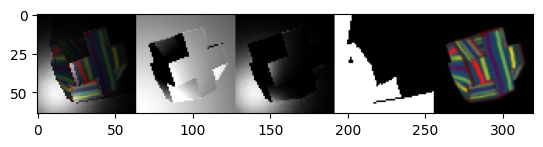

In [99]:
formulaic = myAlbedo * diffdiff * 0.6 + myAlbedo * 0.4 + specspec
plt.imshow(np.clip( np.concatenate([formulaic * 0.4 + formulaic * shadow * 0.6, diffdiff, specspec, shadow, myAlbedo], axis = 1), 0, 1))

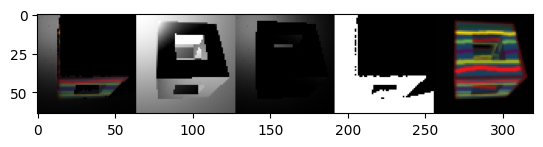

In [24]:
formulaic = myAlbedo * diffdiff * 0.6 + myAlbedo * 0.4 + specspec
plt.imshow(np.clip( np.concatenate([formulaic * shadow, diffdiff, specspec, shadow, myAlbedo], axis = 1), 0, 1))

In [20]:
"""
pos = (32, 32)
light3Dsingular(myNormal[pos[0], pos[1]], myPhoto[pos[0], pos[1]], 
               myVector, 1, 
                pos[0], pos[1],
                myDepth[pos[0], pos[1]], ambient_color = 0.5
               )
"""

'\npos = (32, 32)\nlight3Dsingular(myNormal[pos[0], pos[1]], myPhoto[pos[0], pos[1]], \n               myVector, 1, \n                pos[0], pos[1],\n                myDepth[pos[0], pos[1]], ambient_color = 0.5\n               )\n'

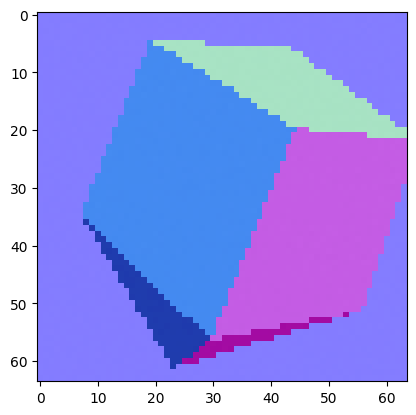

In [15]:
plt.imshow(myNormal.astype("float32"))

In [16]:
def linear3DLight(normal, albedo, depth, vector, specular_color = 0.4, ambient_color = 0, reflection_factor = 5, light_strength = 1):
    local_normal = (normal - 0.5) * 2
    new_photo = np.zeros((64,64,3))
    for x in range(64):
        for y in range(64):
            new_color =  light3Dsingular(local_normal[x,y], albedo[x,y], 
                   vector, 
                    x, y, depth[x, y],
                    specular_color = specular_color,
                    ambient_color = ambient_color,
                    reflection_factor = reflection_factor,
                    light_strength = light_strength
                   )
    
            new_photo[x,y] = new_color
    return new_photo

[-0.593  0.799  0.105]


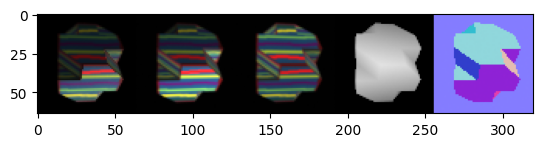

In [109]:
print(myVector)
# -Y, X, Z
#made_up_vector = np.array([myVector[0], myVector[1], myVector[2]])
made_up_vector = np.array([myVector[1], myVector[0], myVector[2]]) * 3 #myVector * 2 #
linear_photo = linear3DLight(myNormal, myAlbedo, myDepth, made_up_vector, 
                             specular_color = 0.2, ambient_color = 0.2, 
                             reflection_factor = 3, light_strength = 4)
linear_photo = linear_photo * myMask * 0.8 + myAlbedo * 0.25
plt.imshow(np.concatenate([linear_photo , myPhoto, myAlbedo, myDepth, myNormal], axis = 1))

In [39]:
r1 = 0.05; r2 = -1.5; r3 = -0.2; d1 = 0.2; d2 = 0; d3 = 0.05;
#r1 = 0; r2 = 0; r3 = 2; d1 = 0; d2 = -0.5; d3 = 0;
vector_list =  [np.array([ d1 + r1 - i * (r1/12), d2 + r2 - i * (r2/12), d3 + r3 - i * (r3/12)]) for i in range(24)]
vector_list2 = [np.array([ d1 + r1 - i * (r1/12), d2 + r2 - i * (r2/12), d3 + r3 - i * (r3/12)]) for i in range(24)]
vector_list2.reverse()
vector_list = vector_list #  + vector_list2

(24, 64, 64, 3)


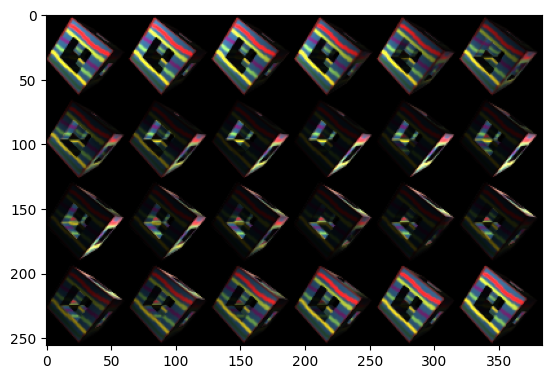

In [58]:
relit_albedos = np.zeros((len(vector_list), 64,64,3))
for i in range(len(vector_list)):
    relit_albedos[i] = linear3DLight(myNormal, myAlbedo, myDepth, vector_list[i], 
                       specular_color = 0.1, ambient_color = 0.15, reflection_factor = 1, light_strength = 3) 
    relit_albedos[i] = relit_albedos[i] * myMask
    #print(vector_list[i])
final_image = np.concatenate([
    np.concatenate(relit_albedos[0:6], axis = 1),
    np.concatenate(relit_albedos[6:12], axis = 1),
    np.concatenate(relit_albedos[12:18], axis = 1),
    np.concatenate(relit_albedos[18:24], axis = 1)   
    ], axis = 0 )
print(relit_albedos.shape)
plt.imshow(final_image)

In [59]:
# GIFMAKER
images_array = (relit_albedos * 255).astype(np.uint8)
images = []
for img in images_array:
    images.append(Image.fromarray(img).resize((128, 128)))

images[0].save('correct_normal.gif',
               save_all=True,
               append_images=images[1:],
               duration=100, 
               loop=0)

In [389]:
def light_up(my_normal, light_point, my_albedo, my_mask):
    light_direction_normalized = (light_point / np.linalg.norm(light_point))
    intensity = np.dot(my_normal, light_direction_normalized)
    intensity = np.clip(intensity, 0, 10)
    intensity = np.stack([intensity, intensity, intensity], axis=2)
    intensity = intensity ** 0.75 #** 0.5
    intensity = intensity * light_color
    
    newThing = (my_albedo * 2 * intensity) * my_mask  # ** (1 / light_intensity)
    return newThing, intensity
# Помоему картинка не складывается потому что в normal map нету объема, 

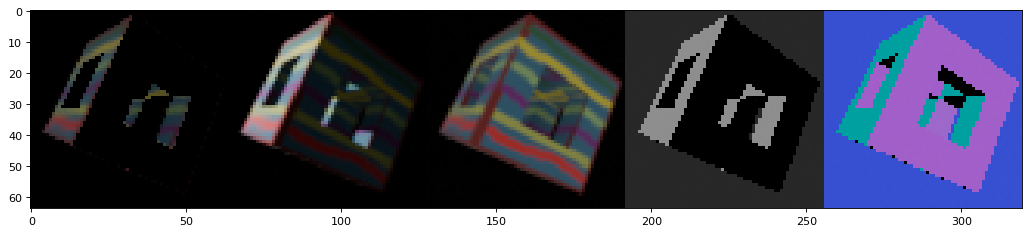

In [83]:
pictoshow, light_map = light_up(myNormal, myVector, myAlbedo, myMask)
plt.figure(figsize=(16, 12), dpi=80)
plt.imshow(np.concatenate([pictoshow, myPhoto, myAlbedo, light_map, myNormal], axis = 1))

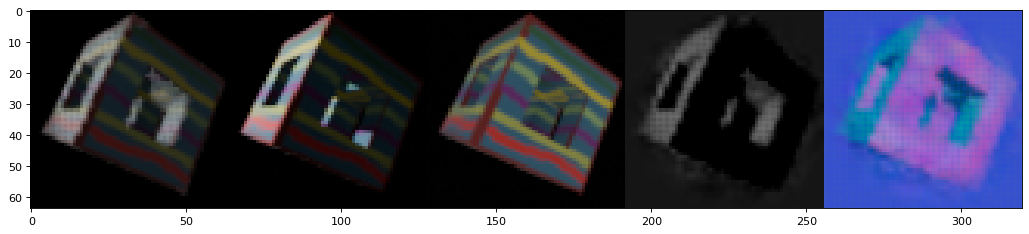

In [11]:
pictoshow, light_map = light_up(blurNormal, myVector, myAlbedo, myMask)
plt.figure(figsize=(16, 12), dpi=80)
plt.imshow(np.concatenate([pictoshow, myPhoto, myAlbedo, light_map, blurNormal], axis = 1))

<b>Вращение источника света и применение плоских нормалей

In [57]:
def rotate_vector(my_vector, degrees):
    x, y = my_vector
    pies = math.radians(degrees)
    new_x = x * math.cos(pies) - y * math.sin(pies)
    new_y = x * math.sin(pies) + y * math.cos(pies)
    return (round(new_x, 2),round(new_y, 2))
    
vector_list = np.zeros((24, 3))
vector_to_add = [-1.5, 0, 0.5]
for i in range(24):
    new_x, new_y = rotate_vector((vector_to_add[0], vector_to_add[1]), 15 * i)
    vector_list[i][0] = new_x
    vector_list[i][1] = new_y
    vector_list[i][2] = vector_to_add[2]
print(vector_list, myVector)


[[-1.5   0.    0.5 ]
 [-1.45 -0.39  0.5 ]
 [-1.3  -0.75  0.5 ]
 [-1.06 -1.06  0.5 ]
 [-0.75 -1.3   0.5 ]
 [-0.39 -1.45  0.5 ]
 [-0.   -1.5   0.5 ]
 [ 0.39 -1.45  0.5 ]
 [ 0.75 -1.3   0.5 ]
 [ 1.06 -1.06  0.5 ]
 [ 1.3  -0.75  0.5 ]
 [ 1.45 -0.39  0.5 ]
 [ 1.5  -0.    0.5 ]
 [ 1.45  0.39  0.5 ]
 [ 1.3   0.75  0.5 ]
 [ 1.06  1.06  0.5 ]
 [ 0.75  1.3   0.5 ]
 [ 0.39  1.45  0.5 ]
 [ 0.    1.5   0.5 ]
 [-0.39  1.45  0.5 ]
 [-0.75  1.3   0.5 ]
 [-1.06  1.06  0.5 ]
 [-1.3   0.75  0.5 ]
 [-1.45  0.39  0.5 ]] [ 0.017 -0.017  1.   ]


In [399]:
relit_albedos = np.zeros((24, 64,64,3))
for i in range(24):
    relit_albedos[i] = light_up(blurNormal, vector_list[i], myAlbedo, myMask)[0]
final_image = np.concatenate([
    np.concatenate(relit_albedos[0:6], axis = 1),
    np.concatenate(relit_albedos[6:12], axis = 1),
    np.concatenate(relit_albedos[12:18], axis = 1),
    np.concatenate(relit_albedos[18:24], axis = 1)   
    ], axis = 0 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.092343520275791].


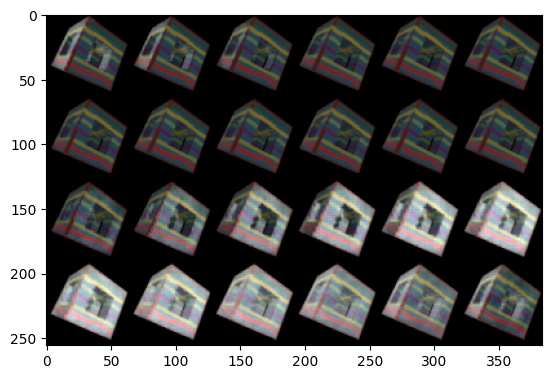

In [400]:
plt.imshow(final_image)

In [5]:
# Обратный процесс можно использовать чтобы получить из освещенного изображения диффузное изображение. 
# Это означает что: В целом нужна только модель нормалей
# Предсказав нормали я могу сначала убрать освещение с картинки, а затем добавить его используя один и тот же механизм
# В этой системе есть проблема: она считает что освещение точечное
# Картинки получены с учетом шарообразного источника света
# Поэтому даже тут они не совсем совпадают

In [6]:
#CONVINIENT TEST:

In [8]:
print(myVector)

[-0.354 -0.707  0.612]


[-0.354 -0.707  0.612]


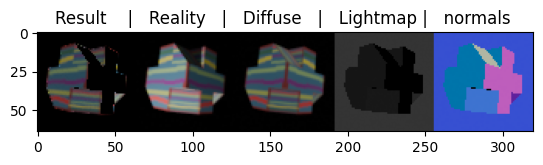

In [12]:
light_intensity = 4
ratio = 1
newThing = myAlbedo * lightmap * light_intensity
newThing = newThing  * ratio + lightmap * (1 - ratio)
newThing = (newThing / np.max( newThing)) * myMask
plt.title("Result    |   Reality   |   Diffuse   |   Lightmap |   normals ")
plt.imshow(np.concatenate([newThing, myPhoto, myAlbedo, lightmap, myNormal], axis = 1))
print(myVector)

C:\Users\Tomil\AppData\Local\Temp\ipykernel_12372\1147676661.py:4: RuntimeWarning: divide by zero encountered in divide
  zeroed = myPhoto / lightmap / light_intensity


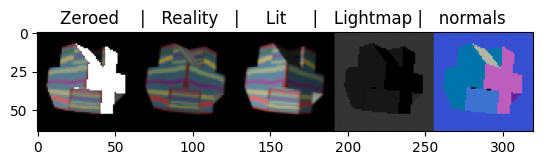

In [13]:
light_intensity = 10
ratio = 0.5

zeroed = myPhoto / lightmap / light_intensity
zeroed = zeroed * myMask
plt.title("Zeroed    |   Reality   |     Lit     |   Lightmap |   normals ")
plt.imshow(np.clip( np.concatenate([zeroed, myAlbedo, myPhoto, lightmap, myNormal], axis = 1), 0, 1))